# リポジトリをクローン

In [1]:
! git clone https://github.com/xuebinqin/DIS
%cd ./DIS/IS-Net

Cloning into 'DIS'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 328 (delta 70), reused 61 (delta 60), pack-reused 246
Receiving objects: 100% (328/328), 49.59 MiB | 23.49 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/DIS/IS-Net


# gdown更新

In [2]:
!pip install onnxruntime
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


# 訓練済み重みダウンロード

In [3]:
!mkdir saved_models

In [4]:
import gdown

gdown.download(
    'https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn', 
    './saved_models/isnet.pth', 
    quiet=False,
)
gdown.download(
    'https://drive.google.com/uc?id=1nV57qKuy--d5u1yvkng9aXW1KS4sOpOi', 
    './saved_models/isnet-general-use.pth', 
    quiet=False,
)

Downloading...
From: https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn
To: /content/DIS/IS-Net/saved_models/isnet.pth
100%|██████████| 177M/177M [00:01<00:00, 166MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nV57qKuy--d5u1yvkng9aXW1KS4sOpOi
To: /content/DIS/IS-Net/saved_models/isnet-general-use.pth
100%|██████████| 177M/177M [00:01<00:00, 167MB/s]


'./saved_models/isnet-general-use.pth'

# 必要パッケージインポート

In [5]:
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import gdown
import os

import requests
import matplotlib.pyplot as plt
from io import BytesIO

# project imports
from data_loader_cache import normalize, im_reader, im_preprocess 
from models import *

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# ヘルパー作成

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class GOSNormalize(object):
    '''
    Normalize the Image using torch.transforms
    '''
    def __init__(self, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
        self.mean = mean
        self.std = std

    def __call__(self,image):
        image = normalize(image,self.mean,self.std)
        return image


transform =  transforms.Compose([GOSNormalize([0.5,0.5,0.5],[1.0,1.0,1.0])])

def load_image(im_path, hypar):
    if im_path.startswith("http"):
        im_path = BytesIO(requests.get(im_path).content)

    im = im_reader(im_path)
    im, im_shp = im_preprocess(im, hypar["cache_size"])
    im = torch.divide(im,255.0)
    shape = torch.from_numpy(np.array(im_shp))
    return transform(im).unsqueeze(0), shape.unsqueeze(0) # make a batch of image, shape


def build_model(hypar,device):
    net = hypar["model"]#GOSNETINC(3,1)

    # convert to half precision
    if(hypar["model_digit"]=="half"):
        net.half()
        for layer in net.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.float()

    net.to(device)

    if(hypar["restore_model"]!=""):
        net.load_state_dict(torch.load(hypar["model_path"]+"/"+hypar["restore_model"],map_location=device))
        net.to(device)
    net.eval()  
    return net

    
def predict(net,  inputs_val, shapes_val, hypar, device):
    '''
    Given an Image, predict the mask
    '''
    net.eval()

    if(hypar["model_digit"]=="full"):
        inputs_val = inputs_val.type(torch.FloatTensor)
    else:
        inputs_val = inputs_val.type(torch.HalfTensor)

  
    inputs_val_v = Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable
   
    ds_val = net(inputs_val_v)[0] # list of 6 results

    pred_val = ds_val[0][0,:,:,:] # B x 1 x H x W    # we want the first one which is the most accurate prediction

    ## recover the prediction spatial size to the orignal image size
    pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))

    ma = torch.max(pred_val)
    mi = torch.min(pred_val)
    pred_val = (pred_val-mi)/(ma-mi) # max = 1

    if device == 'cuda': torch.cuda.empty_cache()
    return (pred_val.detach().cpu().numpy()*255).astype(np.uint8) # it is the mask we need

# パラメータ生成

In [7]:
hypar = {} # paramters for inferencing

hypar["model_path"] ="./saved_models" ## load trained weights from this path
hypar["restore_model"] = "isnet-general-use.pth"  # "isnet.pth" ## name of the to-be-loaded weights
hypar["interm_sup"] = False ## indicate if activate intermediate feature supervision

##  choose floating point accuracy --
hypar["model_digit"] = "full" ## indicates "half" or "full" accuracy of float number
hypar["seed"] = 0

hypar["cache_size"] = [1024, 1024] ## cached input spatial resolution, can be configured into different size

## data augmentation parameters ---
hypar["input_size"] = [1024, 1024] ## mdoel input spatial size, usually use the same value hypar["cache_size"], which means we don't further resize the images
hypar["crop_size"] = [1024, 1024] ## random crop size from the input, it is usually set as smaller than hypar["cache_size"], e.g., [920,920] for data augmentation

hypar["model"] = ISNetDIS()

# モデルビルド

In [8]:
net = build_model(hypar, device)

# ONNX変換

In [9]:
def convert_to_onnx(net, file_name='output.onnx', input_shape=(512, 512), device='cpu'):
    input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

    input_layer_names = ['input_image']
    output_layer_names = ['output_image']

    torch.onnx.export(
        net, 
        input, 
        file_name, 
        verbose=True,
        opset_version=13,
        input_names=input_layer_names,
        output_names=output_layer_names,
    )

In [10]:
convert_to_onnx(net, file_name='isnet-general-use.onnx', input_shape=(1024, 1024))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:687: UserWarning: The shape infe

# 推論テスト

### サンプル画像ダウンロード

In [11]:
!wget https://user-images.githubusercontent.com/37477845/221342428-6885057c-ee00-4ccf-8996-0c7a55e928ab.jpg -O test.jpg

--2023-02-25 09:02:42--  https://user-images.githubusercontent.com/37477845/221342428-6885057c-ee00-4ccf-8996-0c7a55e928ab.jpg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 677982 (662K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 662.09K  --.-KB/s    in 0.04s   

2023-02-25 09:02:42 (15.1 MB/s) - ‘test.jpg’ saved [677982/677982]



In [12]:
import cv2
image = cv2.imread('test.jpg')

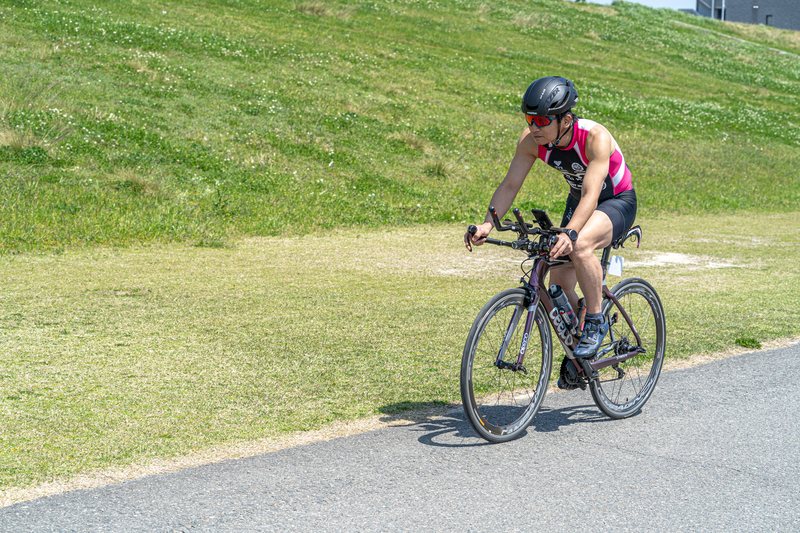

In [13]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

### 推論準備

In [14]:
def run_inference(onnx_session, image, score_th=None):
    # ONNX Input Size
    input_size = onnx_session.get_inputs()[0].shape
    input_width = input_size[3]
    input_height = input_size[2]

    # Pre process:Resize, BGR->RGB, float32 cast
    input_image = cv2.resize(image, dsize=(input_width, input_height))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    mean = [0.5, 0.5, 0.5]
    std = [1.0, 1.0, 1.0]
    input_image = (input_image / 255.0 - mean) / std
    input_image = input_image.transpose(2, 0, 1)
    input_image = np.expand_dims(input_image, axis=0)
    input_image = input_image.astype('float32')

    # Inference
    input_name = onnx_session.get_inputs()[0].name
    output_name = onnx_session.get_outputs()[0].name
    result = onnx_session.run([output_name], {input_name: input_image})

    # Post process:squeeze, Sigmoid, Normarize, uint8 cast
    mask = np.squeeze(result[0])
    min_value = np.min(mask)
    max_value = np.max(mask)
    mask = (mask - min_value) / (max_value - min_value)
    if score_th is not None:
        mask = np.where(mask < score_th, 0, 1)
    mask *= 255
    mask = mask.astype('uint8')

    return mask

In [15]:
import onnxruntime

onnx_session = onnxruntime.InferenceSession(
    'isnet-general-use.onnx',
    providers=[
        'CUDAExecutionProvider',
        'CPUExecutionProvider',
    ],
)

/usr/local/lib/python3.8/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


### 推論

In [16]:
mask = run_inference(
    onnx_session,
    image,
    score_th=0.5,
)

# 推論結果確認

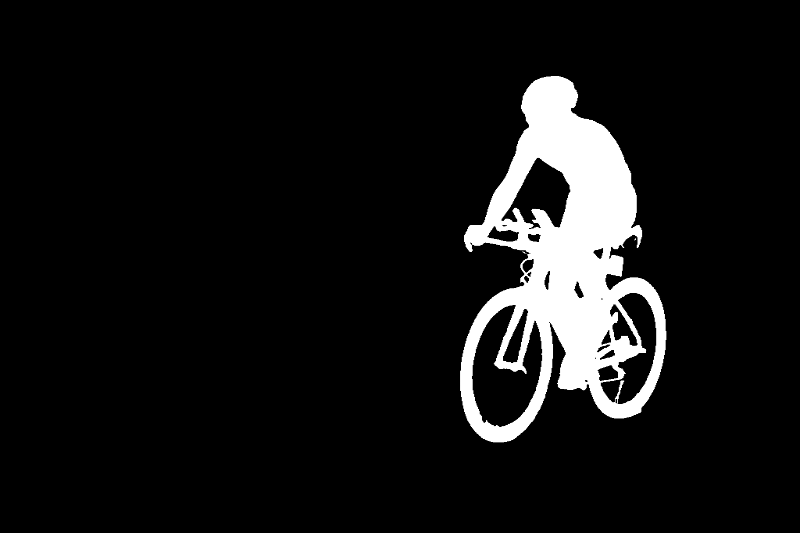

In [17]:
# 入力画像と同じサイズにリサイズ
mask = cv2.resize(
    mask,
    dsize=(image.shape[1], image.shape[0]),
)

# 表示
cv2_imshow(mask)

### マスクでの切り抜き確認

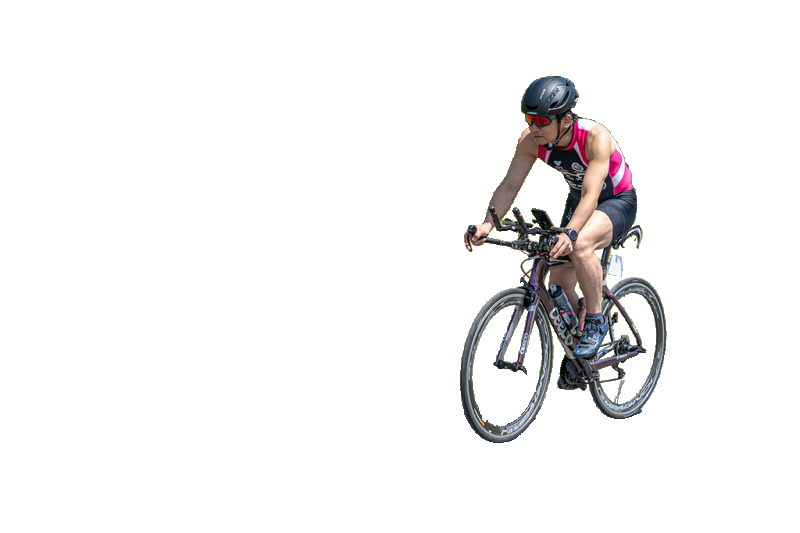

In [18]:
# マスクを用いた切り抜き
overlay_image = np.zeros(image.shape, dtype=np.uint8)
overlay_image[:] = (255, 255, 255)
mask = np.stack((mask, ) * 3, axis=-1).astype('uint8')
mask_image = np.where(mask, image, overlay_image)

# 表示
cv2_imshow(mask_image)